In [201]:
import glob
import multiprocessing
import random
import time
import enum

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchio as tio
import torchvision
from tqdm import tqdm

from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import visualize_subject, visualize_slice
from scripts.utils.loading import get_subjects_names
from scripts.load_data import load_2D, load_3D
seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run on Thu Jul  6 17:47:17 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [3]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata.head(5)

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:16<00:00,  9.12it/s]


Training/Labeled/ Dataset size: 150 subjects
Memory function not implemented for 2D
Total memory for train:  None
Subject(Keys: ('image', 'seg'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)


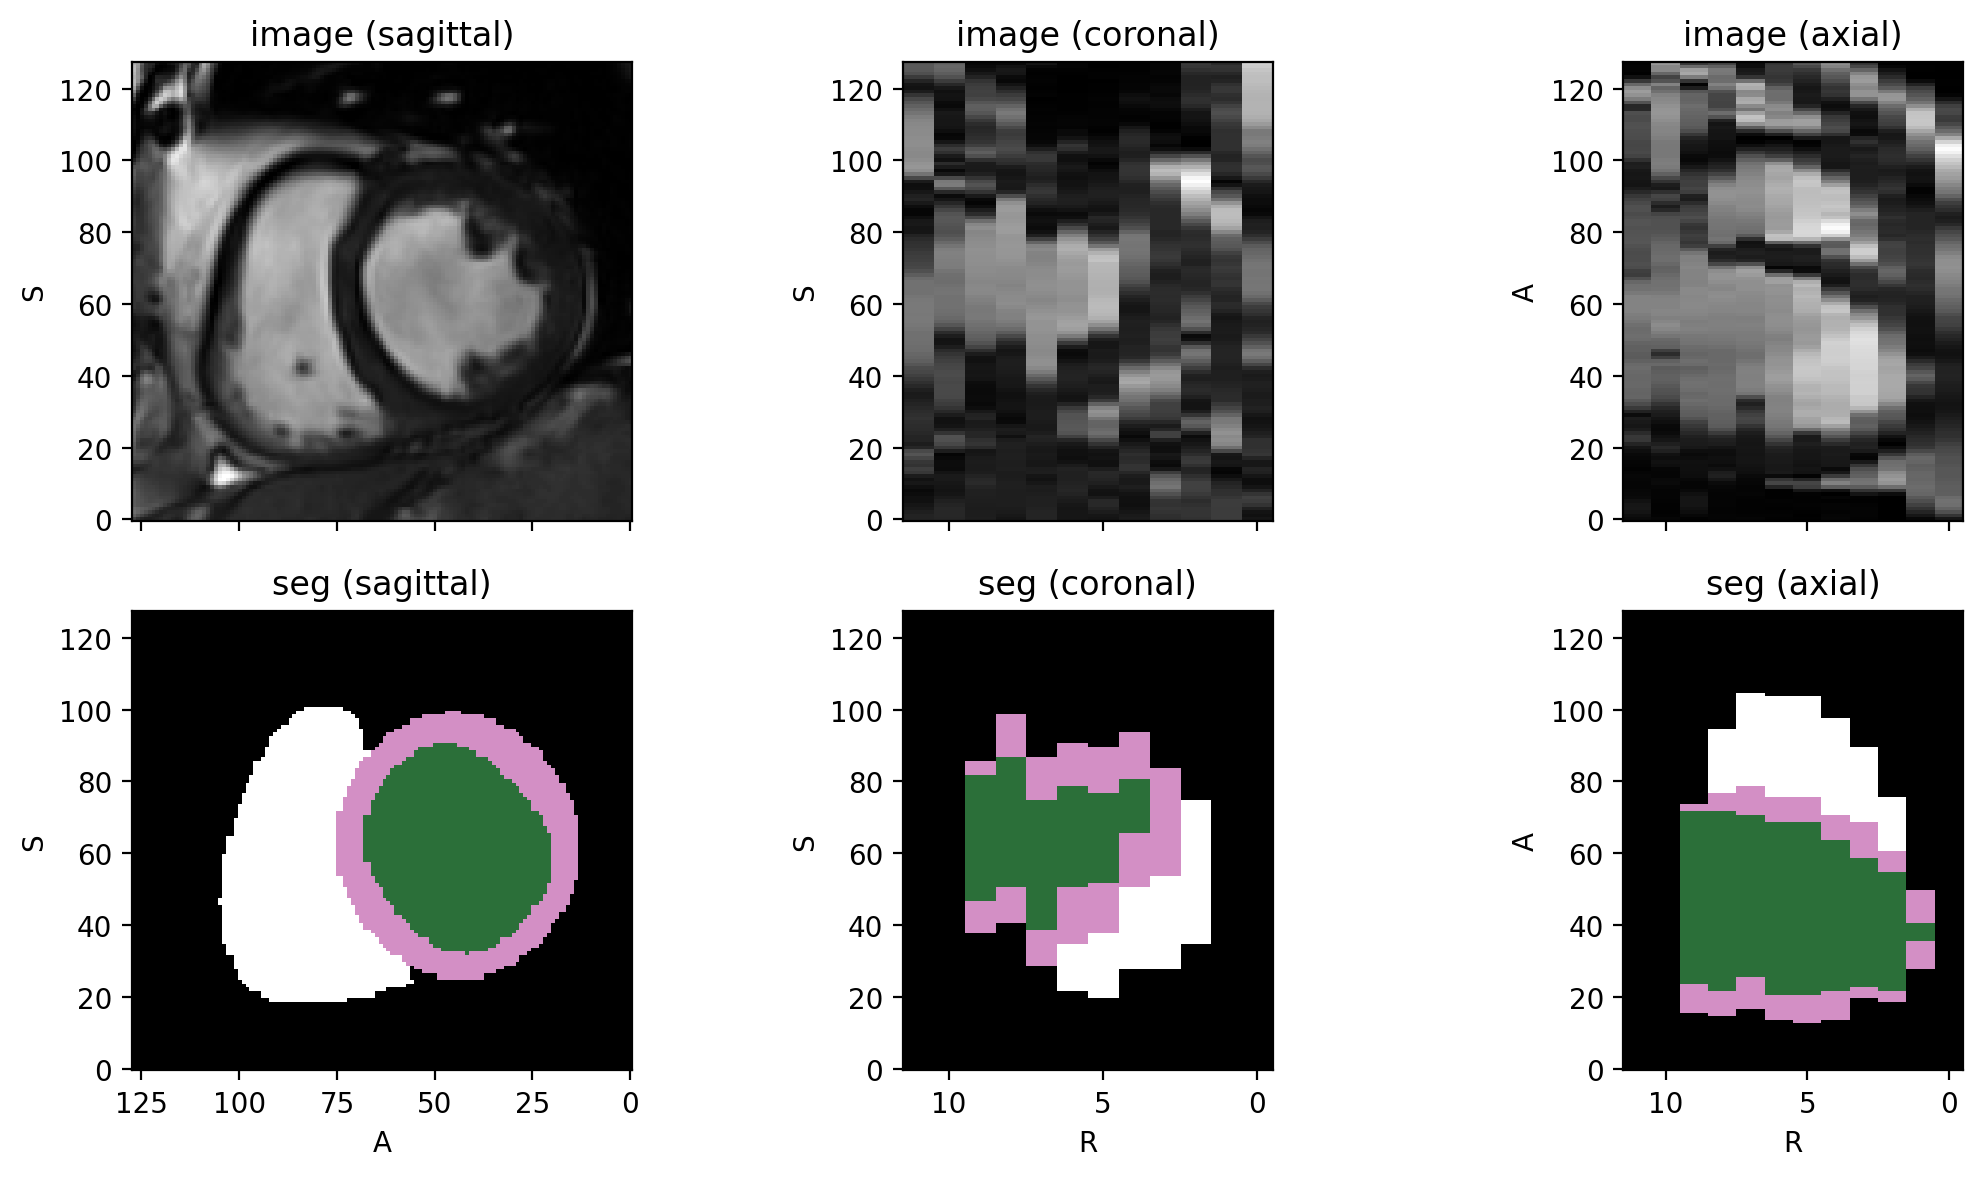

In [58]:
train_dataset_3D = load_3D("Training/Labeled/")
print("Total memory for train: ", get_total_memory(train_dataset_3D))
one_subject = train_dataset_3D[0]
visualize_subject(one_subject)

100%|██████████| 150/150 [00:16<00:00,  9.08it/s]


Training/Labeled/ Dataset size: 3286 subjects


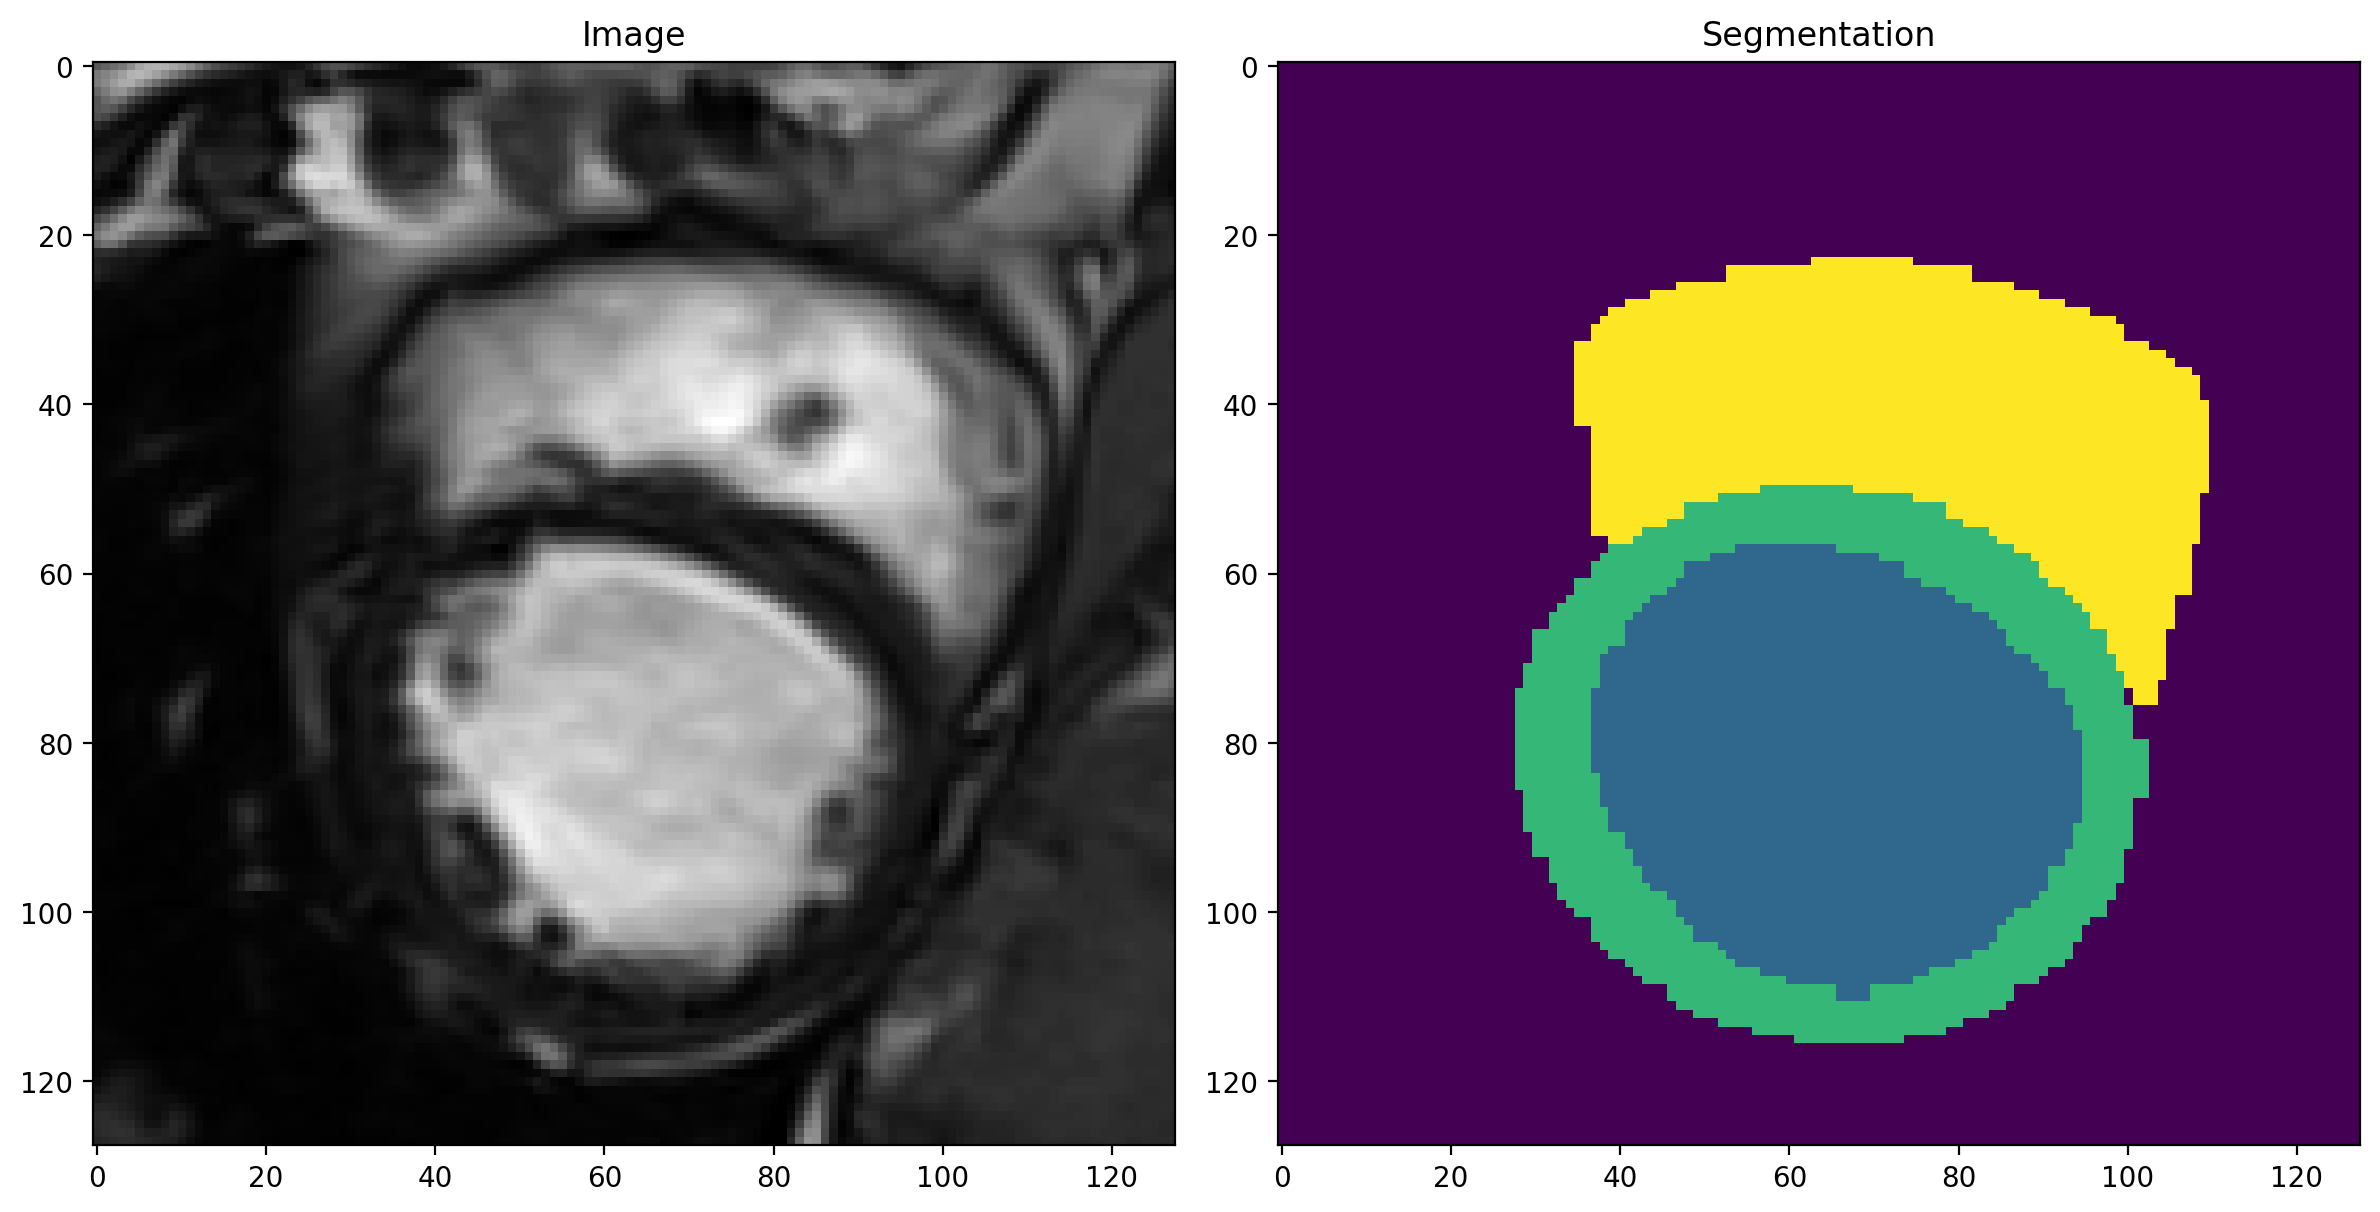

In [106]:
train_dataset = load_2D("Training/Labeled/")
image = train_dataset[10][0]
seg = train_dataset[10][1]
visualize_slice(image, seg)

In [204]:
# # C8J7L5 was removed from valid
valid_dataset = load_2D("Validation/")
# #E3F5U2, C8O0P2 were removed from test
# test_dataset = load_2D("Testing/")

100%|██████████| 33/33 [00:06<00:00,  4.99it/s]


Validation/ Dataset size: 786 subjects


# Unet

In [166]:
training_batch_size = 8
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=2,
)

dataiter = iter(training_loader)
images, labels = next(dataiter)

In [167]:
images.shape

torch.Size([8, 1, 128, 128])

In [234]:
def imshow(img, seg=None):
    npimg = img.numpy()[0]
    plt.figure(figsize=(4,8))
    plt.imshow(npimg, "gray")
    if seg is not None:
        seg = seg.numpy()[0]
        cmap = plt.colormaps.get_cmap('jet')
        masked = np.ma.masked_where(seg == 0, seg)
        plt.imshow(masked, cmap=cmap, alpha=0.7)

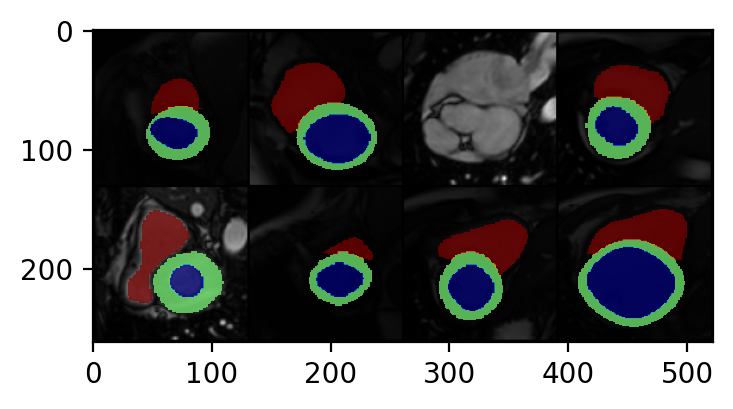

In [235]:
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images,nrow=4), torchvision.utils.make_grid(labels,nrow=4))

In [238]:
batch_size = 64
num_classes = 4


training_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    )

validation_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=10
    )

num_epochs = 200
total_steps = len(training_loader)

model = UNet(
    in_channels=1,
    out_classes=4,
    dimensions=2,
    num_encoding_blocks=4,
    out_channels_first_layer=8,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
).to(device)
model.to(device)


optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, (images_batch, labels_batch) in enumerate(training_loader):
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch%10==0:
        print(f"Epoch [{epoch+1}/{num_epochs}]], Loss: {loss.item():.4f}")


  0%|          | 1/200 [00:05<18:05,  5.45s/it]

Epoch [1/200]], Loss: 0.6820


  6%|▌         | 11/200 [01:01<17:45,  5.64s/it]

Epoch [11/200]], Loss: 0.1318


 10%|█         | 21/200 [01:55<16:04,  5.39s/it]

Epoch [21/200]], Loss: 0.0631


 16%|█▌        | 31/200 [02:48<15:12,  5.40s/it]

Epoch [31/200]], Loss: 0.0530


 20%|██        | 41/200 [03:42<14:16,  5.39s/it]

Epoch [41/200]], Loss: 0.0526


 26%|██▌       | 51/200 [04:36<13:25,  5.41s/it]

Epoch [51/200]], Loss: 0.0445


 30%|███       | 61/200 [05:30<12:31,  5.41s/it]

Epoch [61/200]], Loss: 0.0494


 36%|███▌      | 71/200 [06:24<11:36,  5.40s/it]

Epoch [71/200]], Loss: 0.0292


 40%|████      | 81/200 [07:20<11:12,  5.65s/it]

Epoch [81/200]], Loss: 0.0752


 46%|████▌     | 91/200 [08:15<09:59,  5.50s/it]

Epoch [91/200]], Loss: 0.0260


 50%|█████     | 101/200 [09:10<08:55,  5.41s/it]

Epoch [101/200]], Loss: 0.0284


 56%|█████▌    | 111/200 [10:04<08:03,  5.43s/it]

Epoch [111/200]], Loss: 0.0506


 60%|██████    | 121/200 [10:58<07:08,  5.43s/it]

Epoch [121/200]], Loss: 0.0283


 66%|██████▌   | 131/200 [11:53<06:12,  5.40s/it]

Epoch [131/200]], Loss: 0.0314


 70%|███████   | 141/200 [12:47<05:20,  5.42s/it]

Epoch [141/200]], Loss: 0.0238


 76%|███████▌  | 151/200 [13:41<04:25,  5.42s/it]

Epoch [151/200]], Loss: 0.0255


 80%|████████  | 161/200 [14:36<03:31,  5.43s/it]

Epoch [161/200]], Loss: 0.0244


 86%|████████▌ | 171/200 [15:30<02:36,  5.41s/it]

Epoch [171/200]], Loss: 0.0210


 90%|█████████ | 181/200 [16:25<01:43,  5.47s/it]

Epoch [181/200]], Loss: 0.0349


 96%|█████████▌| 191/200 [17:19<00:49,  5.47s/it]

Epoch [191/200]], Loss: 0.0246


100%|██████████| 200/200 [18:08<00:00,  5.44s/it]


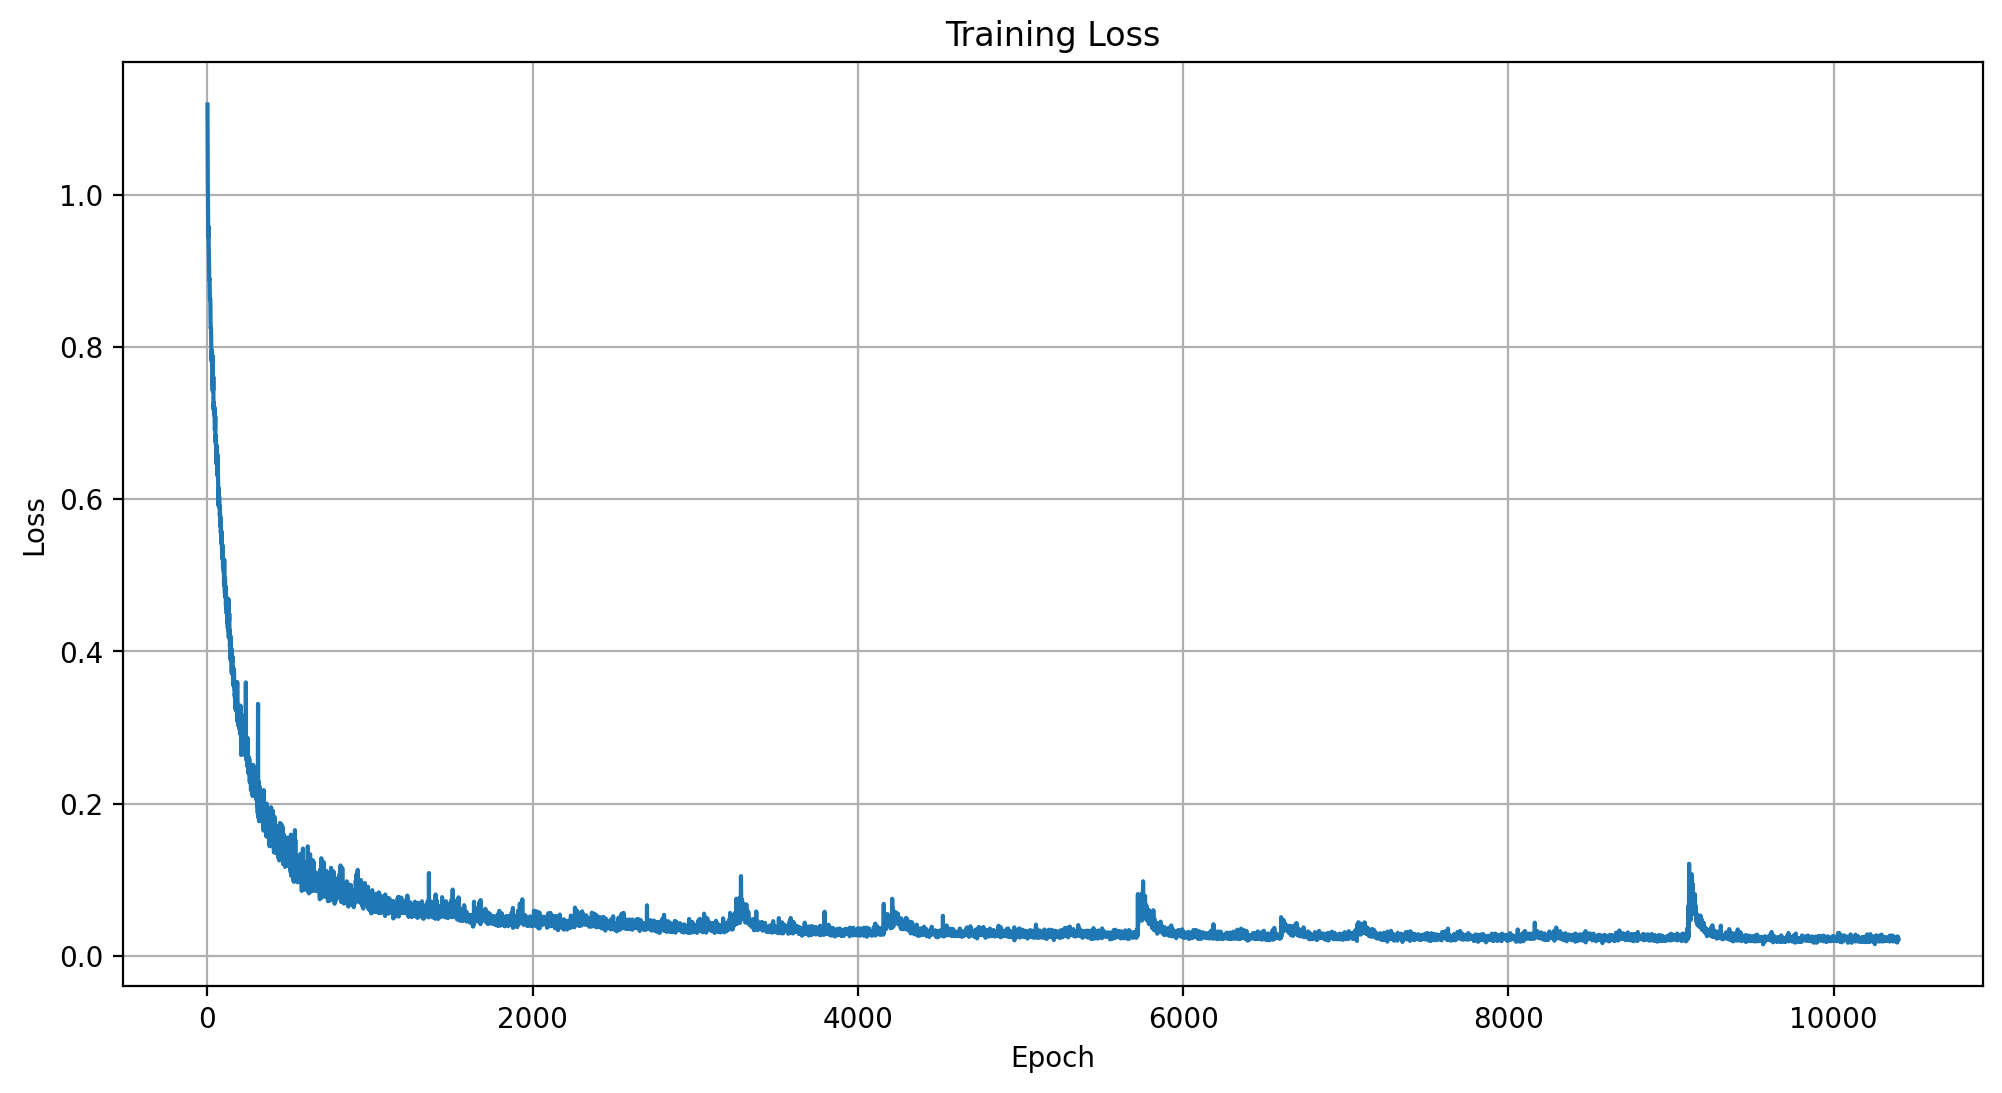

In [240]:
plt.plot(range(10400) , losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

In [241]:
valid_iter = iter(validation_loader)

In [242]:
validation_batch = next(valid_iter)
images, ground_truths = validation_batch
images = images.to('cuda')

with torch.no_grad():
    output = model(images)

print(output.shape)
probabilities = torch.softmax(output, dim=1)
_, predictions = torch.max(probabilities, dim=1)
print(predictions.shape)

predictions = predictions.cpu()


torch.Size([64, 4, 128, 128])
torch.Size([64, 128, 128])


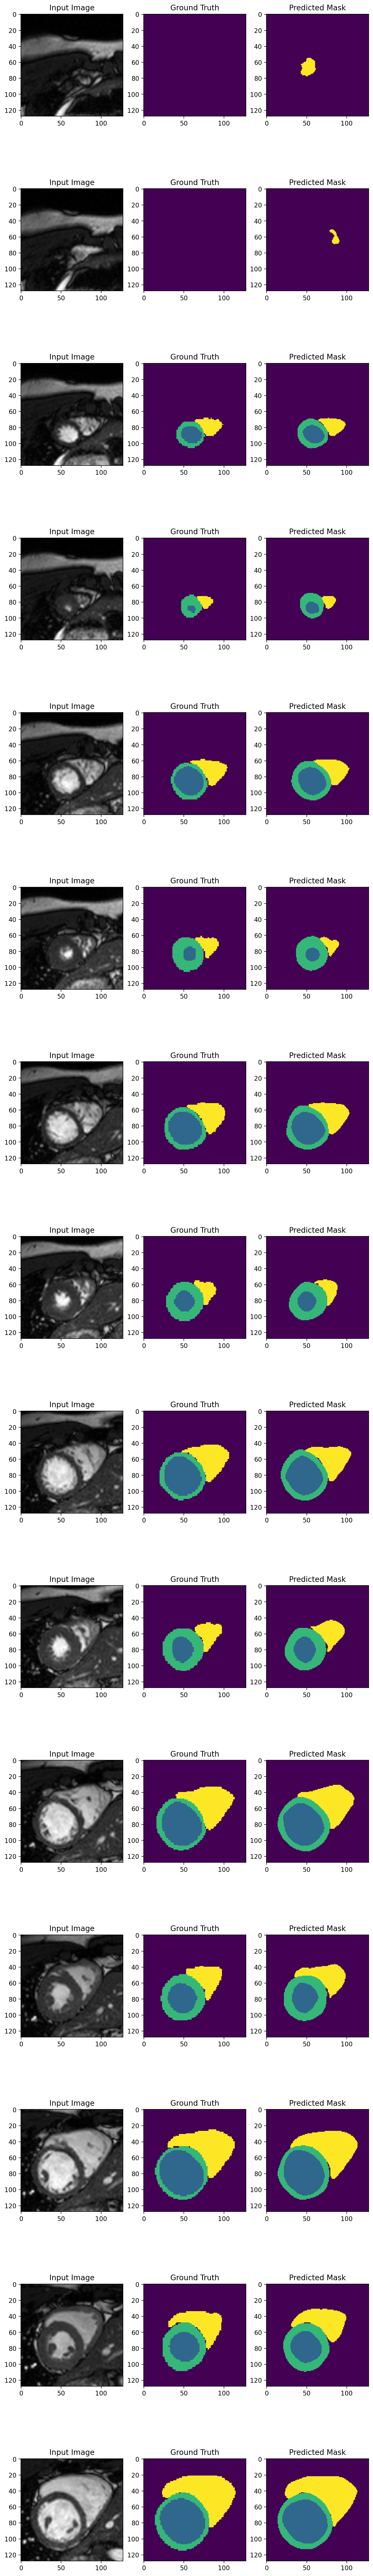

In [243]:
n_examples = 15
plt.figure(figsize=(10, 5 * n_examples))

for i in range(n_examples):
    input_image = images[i].cpu()
    ground_truth = ground_truths[i].cpu()
    predicted_mask = predictions[i]

    input_image = input_image.permute(1, 2, 0).numpy()
    ground_truth = ground_truth.permute(1, 2, 0).numpy()
    predicted_mask = predicted_mask.numpy()

    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')

    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')

    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')

plt.show()

torch.Size([64, 4, 128, 128])
torch.Size([64, 128, 128])


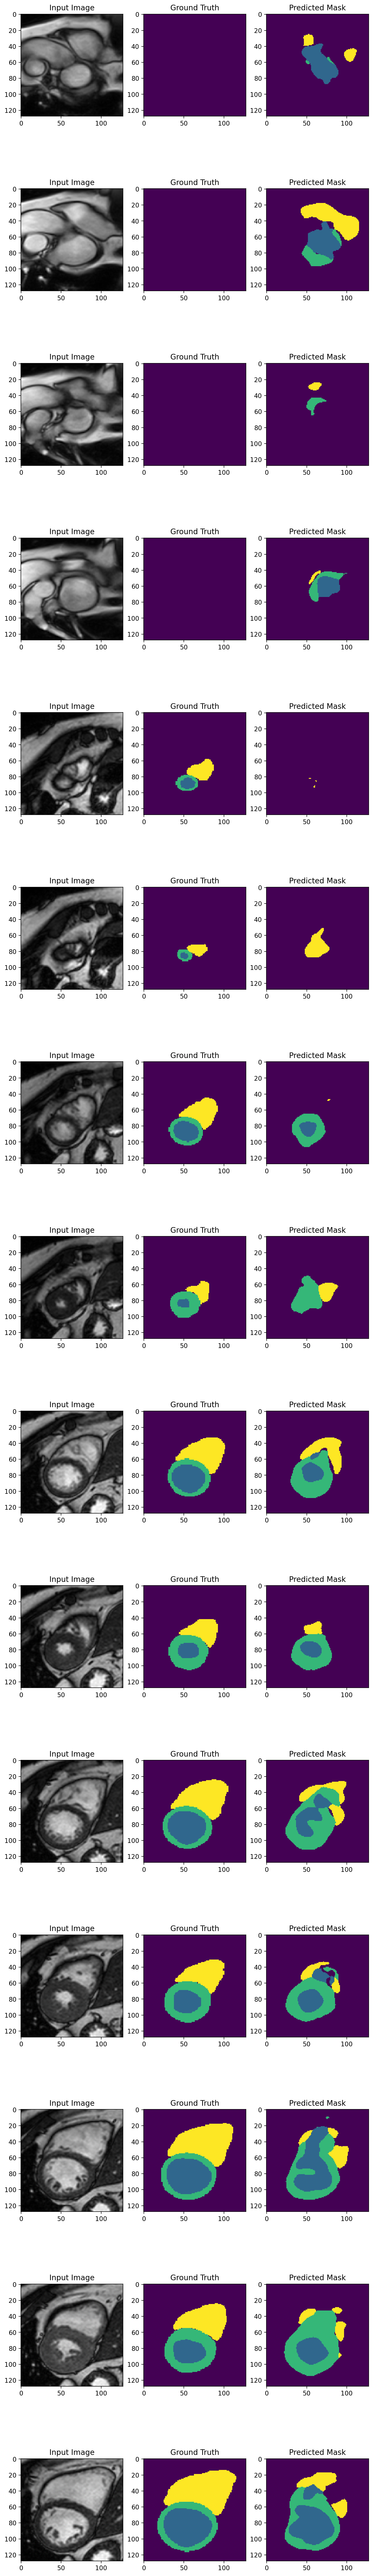

In [245]:
validation_batch = next(valid_iter)
images, ground_truths = validation_batch
images = images.to('cuda')

with torch.no_grad():
    output = model(images)

print(output.shape)
probabilities = torch.softmax(output, dim=1)
_, predictions = torch.max(probabilities, dim=1)
print(predictions.shape)

predictions = predictions.cpu()

n_examples = 15
plt.figure(figsize=(10, 5 * n_examples))

for i in range(n_examples):
    input_image = images[i].cpu()
    ground_truth = ground_truths[i].cpu()
    predicted_mask = predictions[i]

    input_image = input_image.permute(1, 2, 0).numpy()
    ground_truth = ground_truth.permute(1, 2, 0).numpy()
    predicted_mask = predicted_mask.numpy()

    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')

    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')

    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')

plt.show()